## Regressão simbólica aplicada ao modelo populacional de Verhulst

In [1]:
from deap import base, creator, tools, gp
from deap.algorithms import eaSimple
import math
import numpy
import operator
import random as rd
import lmfit
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
from sympy import Symbol, expand
from funcoes import malthus, runge_kutta

### Solução numérica para o modelo dada pelo método de Runge-Kutta

In [2]:
T0 = 0
TF = 1
H = 0.01
X0 = 3
K = 1

T, X = runge_kutta(malthus, T0, X0, TF, H, K)

In [3]:
NUM_GERACOES = 500
TAMANHO_POP = 1000
TAMANHO_TORNEIO = 3
CHANCE_CRUZAMENTO = 0.5
CHANCE_MUTACAO = 0.03

In [4]:
def Div(left, right):
    if type(right) == float:
        if right == 0:
            #print('div error')
            return 1
        else:
            return left / right
    else:
        # Replace zero terms in the divider array with 1
        right_without_zeros = np.where(right == 0, 1, right)

        # Perform element-wise division
        result = left / right_without_zeros
        return result

def Exp(x):
    try:
        result = np.exp(x)
    except OverflowError:
        print('exp error')
        result = np.ones_like(x)
    return result

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(np.cos, 1)
#pset.addPrimitive(np.sin, 1)
pset.addPrimitive(Exp, 1)

#pset.addPrimitive(X0_add, 1)
#pset.addPrimitive(X0_mul, 1)
#pset.addPrimitive(X0_div, 1)
#pset.addPrimitive(K_add, 1)
#pset.addPrimitive(K_mul, 1)
#pset.addPrimitive(K_div, 1)

pset.addEphemeralConstant("rand101", lambda: rd.randint(-1,1))

pset.renameArguments(ARG0='t')

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [6]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [7]:
def fitness(individual, points):
    # solução numérica:
    # Transformar a expressão em função:
    func = toolbox.compile(expr=individual)
    Xexpr = func(T)
    RMSE = np.sqrt(sum((Xexpr - X)**2))
    tamanho = len(str(individual))
    if tamanho > 50:
        return float('inf'),
    else:
        return (RMSE**1) * (1+tamanho/5)**0,

In [8]:
toolbox.register("evaluate", fitness, points = list(np.arange(T0, TF + H, H)))
toolbox.register("select", tools.selTournament, tournsize=TAMANHO_TORNEIO)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [9]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)

In [10]:
pop = toolbox.population(n=TAMANHO_POP)
hof = tools.HallOfFame(5)
pop, log = eaSimple(pop, toolbox,
                cxpb=CHANCE_CRUZAMENTO,mutpb=CHANCE_MUTACAO, 
                ngen=NUM_GERACOES , stats=mstats, halloffame=hof, verbose=True)

   	      	                fitness                	                  size                 
   	      	---------------------------------------	---------------------------------------
gen	nevals	avg    	gen	min    	nevals	std    	avg  	gen	min	nevals	std    
0  	1000  	64.4657	0  	5.06825	1000  	327.746	3.876	0  	2  	1000  	1.61636
1  	537   	57.956 	1  	5.06825	537   	356.348	3.682	1  	1  	537   	1.57508
2  	489   	5.37623e+40	2  	3.55494	489   	1.20096e+42	3.769	2  	2  	489   	1.7122 


C:\Users\ANA220~1\AppData\Local\Temp/ipykernel_24144/2186209511.py:18: RuntimeWarning: overflow encountered in exp
  result = np.exp(x)
C:\Users\ANA220~1\AppData\Local\Temp/ipykernel_24144/1863226702.py:6: RuntimeWarning: overflow encountered in square
  RMSE = np.sqrt(sum((Xexpr - X)**2))
c:\venv\ilumpy\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


3  	537   	inf        	3  	3.55494	537   	nan        	4.017	3  	1  	537   	1.77446
4  	480   	inf        	4  	3.55494	480   	nan        	4.301	4  	1  	480   	1.80898
5  	565   	inf        	5  	3.55494	565   	nan        	4.449	5  	1  	565   	1.69334
6  	509   	1.13104e+115	6  	3.55494	509   	3.57489e+116	4.614	6  	1  	509   	1.7621 
7  	502   	39.0638     	7  	1.55263	502   	388.712     	4.531	7  	1  	502   	1.67124
8  	522   	inf         	8  	1.55263	522   	nan         	4.616	8  	1  	522   	1.74887
9  	522   	2.19212e+41 	9  	1.55263	522   	3.99623e+42 	4.799	9  	1  	522   	1.8933 
10 	548   	inf         	10 	1.55263	548   	nan         	5.163	10 	1  	548   	2.22316
11 	495   	inf         	11 	1.55263	495   	nan         	5.584	11 	1  	495   	2.22777
12 	525   	inf         	12 	1.55263	525   	nan         	6.179	12 	2  	525   	2.29324
13 	491   	inf         	13 	1.55263	491   	nan         	6.707	13 	2  	491   	2.24213
14 	498   	inf         	14 	1.55263	498   	nan         	7.079	14 	1  	4

In [11]:
for i in hof.items:
    print(str(i))
    print()

add(Exp(add(1, t)), Exp(Div(-1, Exp(mul(t, t)))))

add(Exp(Div(-1, Exp(mul(t, t)))), Exp(sub(t, -1)))

add(Exp(add(t, 1)), Exp(Div(-1, Exp(mul(t, t)))))

add(Exp(Div(-1, Exp(mul(t, t)))), Exp(add(t, 1)))

add(Exp(Div(-1, Exp(mul(t, t)))), Exp(add(1, t)))



### Reportando melhor individuo encontrado 

add(Exp(add(1, t)), Exp(Div(-1, Exp(mul(t, t)))))


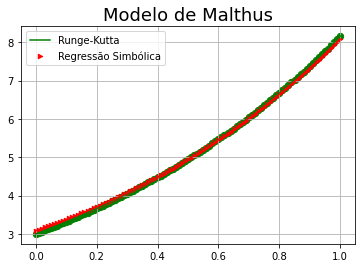

In [12]:
melhor_individuo = str(hof.items[0])
#melhor_individuo_ever = 'X0_mul(Exp(K_mul(t)))'
print(melhor_individuo)
func = toolbox.compile(expr=melhor_individuo)
Xexpr = func(T)
#func = toolbox.compile(expr=melhor_individuo_ever)
#Xbest = func(T)
fig, ax = plt.subplots(1,1)
ax.set_title('Modelo de Malthus', size = 18)
ax.scatter(T, X, c = 'g', s = 40)
ax.plot(T, X, label = 'Runge-Kutta', c = 'g')
ax.scatter(T, Xexpr, label = 'Regressão Simbólica', marker = '>', c = 'r', s = 20)
ax.plot(T, Xexpr, c = 'r')
#ax.plot(T, Xbest, label = 'Analitica', c = '0')
ax.legend()

ax.legend()
ax.grid('--')
#plt.savefig('resultados\Resultado_Malthus_1.png', dpi = 200)

### Reportando o melhor individuo encontrado

In [13]:
def Div(left, right):
    return left / right

def Exp(x):
    return sp.exp(x)

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def X0_sub(x):
    return x - X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K

def k_sub(x):
    return x - K

    
new_pset = gp.PrimitiveSet("MAIN", 1)

new_pset.addPrimitive(operator.add, 2)
new_pset.addPrimitive(operator.sub, 2)
new_pset.addPrimitive(operator.mul, 2)
new_pset.addPrimitive(Div, 2)
new_pset.addPrimitive(operator.neg, 1)
new_pset.addPrimitive(sp.cos, 1)
new_pset.addPrimitive(sp.sin, 1)
new_pset.addPrimitive(Exp, 1)


new_pset.addEphemeralConstant("rand102", lambda: rd.randint(-1,1))

new_pset.renameArguments(ARG0='t')
toolbox.register("compile", gp.compile, pset=new_pset)

In [14]:
func = toolbox.compile(expr=melhor_individuo)
t = Symbol('t')
X0 = Symbol('X_0')
K = Symbol('k')

In [15]:
display(sp.expand(func(t)))

E*exp(t) + exp(-exp(-t**2))